In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
plt.style.use('ggplot')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [26]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [27]:
df = pd.read_csv('data/CVD_cleaned.csv')
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [28]:
print('dataset dimension:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print(df.columns)

dataset dimension: (308854, 19)
fraction of missing values in features:
Series([], dtype: float64)
Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')


### EDA

In [29]:
df['Heart_Disease'].value_counts()[1]/len(df)*100

8.085049894124733

<Figure size 500x400 with 0 Axes>

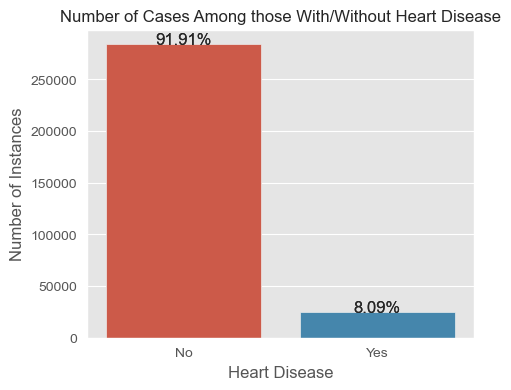

In [30]:
plt.figure(figsize=(5,4))
plt.figure(figsize=(5,4))
g = sns.countplot(data=df, x='Heart_Disease')
sns.countplot(df, x = 'Heart_Disease')
plt.ylabel('Number of Instances')
plt.xlabel('Heart Disease')
plt.title('Number of Cases Among those With/Without Heart Disease', fontsize=12)
total = len(df)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center",
            fontsize = 12) 

<Axes: xlabel='count', ylabel='Age_Category'>

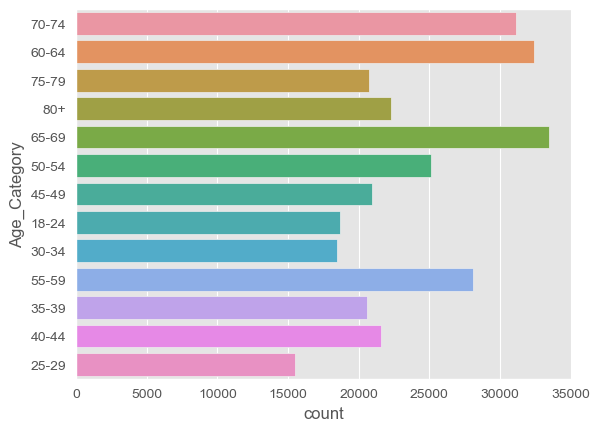

In [31]:
#sns.countplot(df, x = 'General_Health')
sns.countplot(df, y = 'Age_Category')

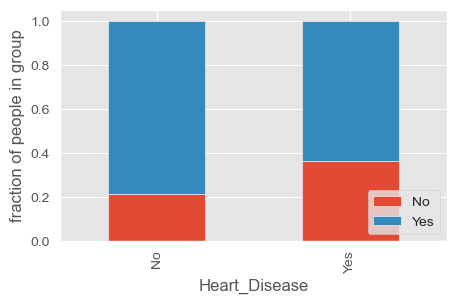

In [32]:
count_matrix = df.groupby(['Heart_Disease','Exercise']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of people in group')
plt.legend(loc=4);

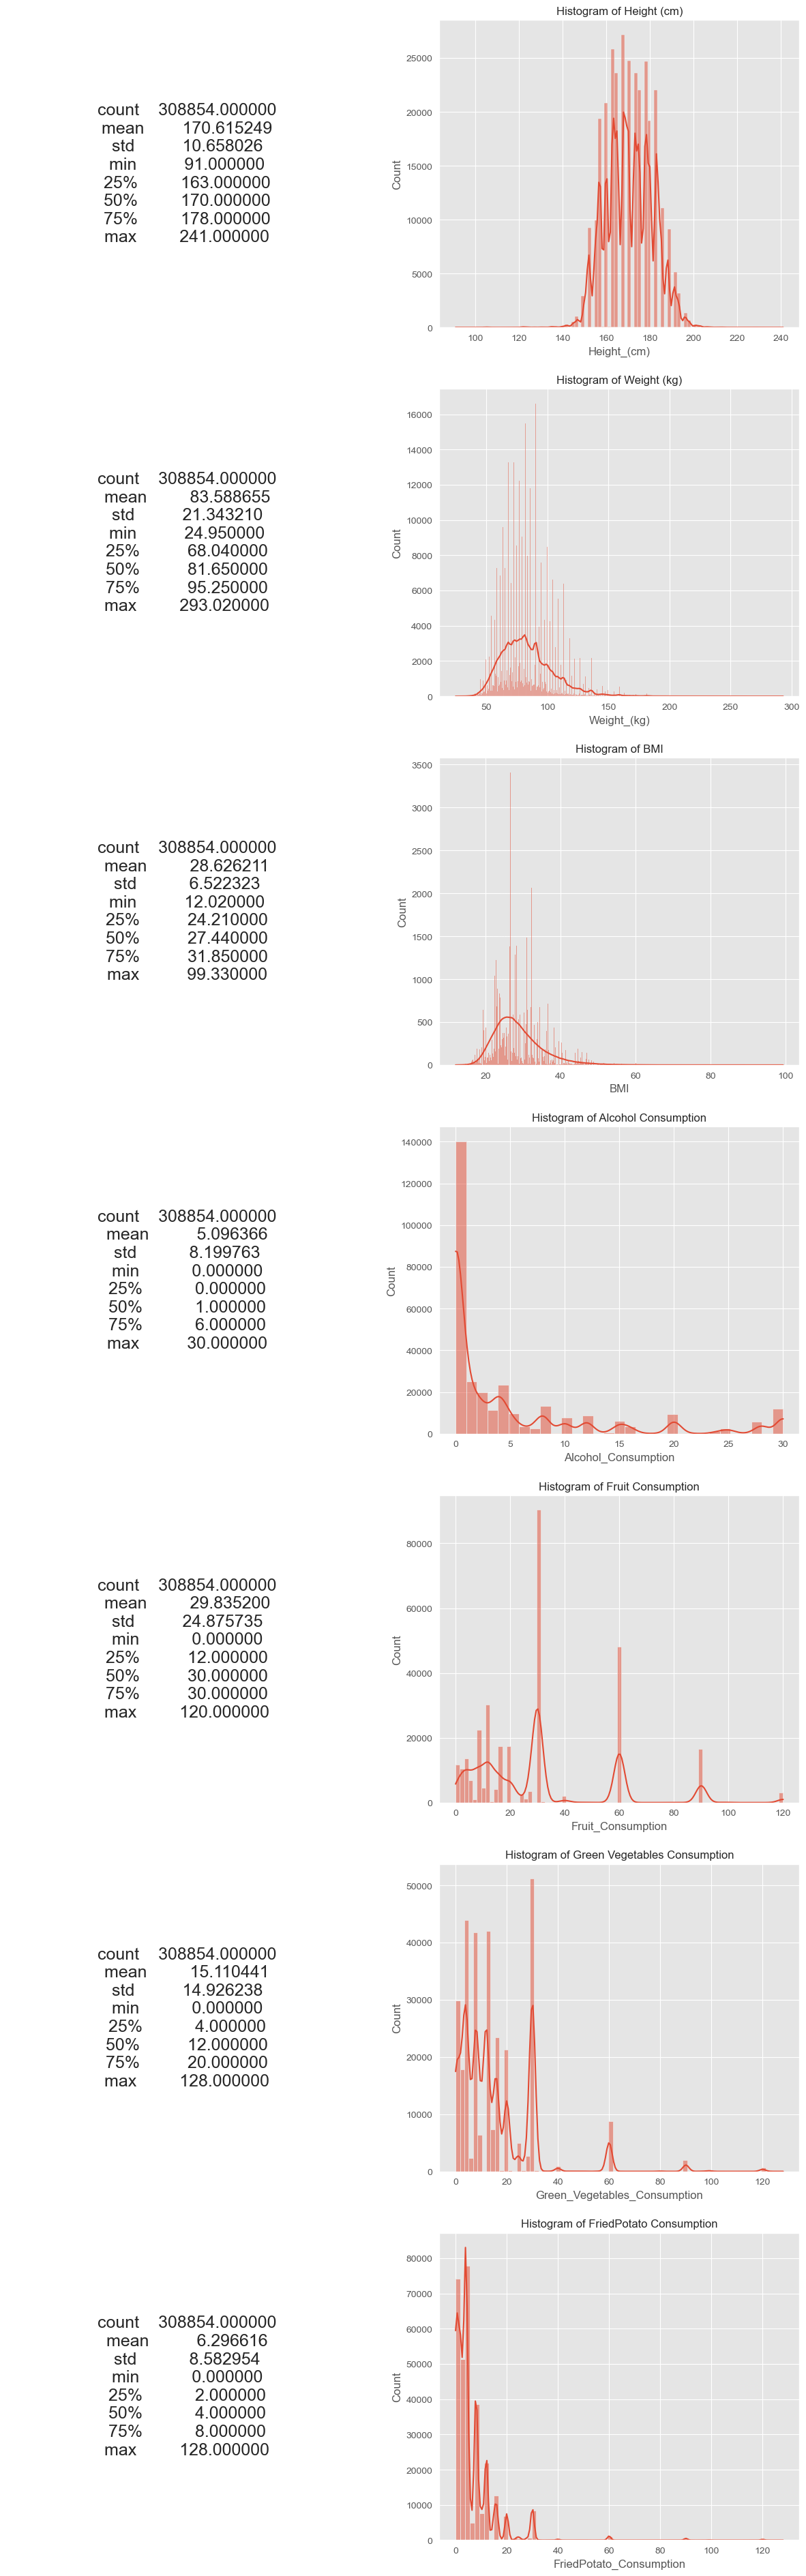

In [33]:
continuous_features = ['Height_(cm)', 'Weight_(kg)', 'BMI','Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=2, figsize=(15, 48))

for i, col in enumerate(continuous_features):
    axes[i, 0].axis('off')
    stats = df[col].describe().to_string()
    axes[i, 0].text(0.5, 0.5, stats, fontsize=18, ha='center', va='center')
    

    sns.histplot(df[col], bins=df[col].nunique(), kde=True, ax=axes[i, 1])

    title = f'Histogram of {col.replace("_", " ")}'
    axes[i, 1].set_title(title).set_size(12)

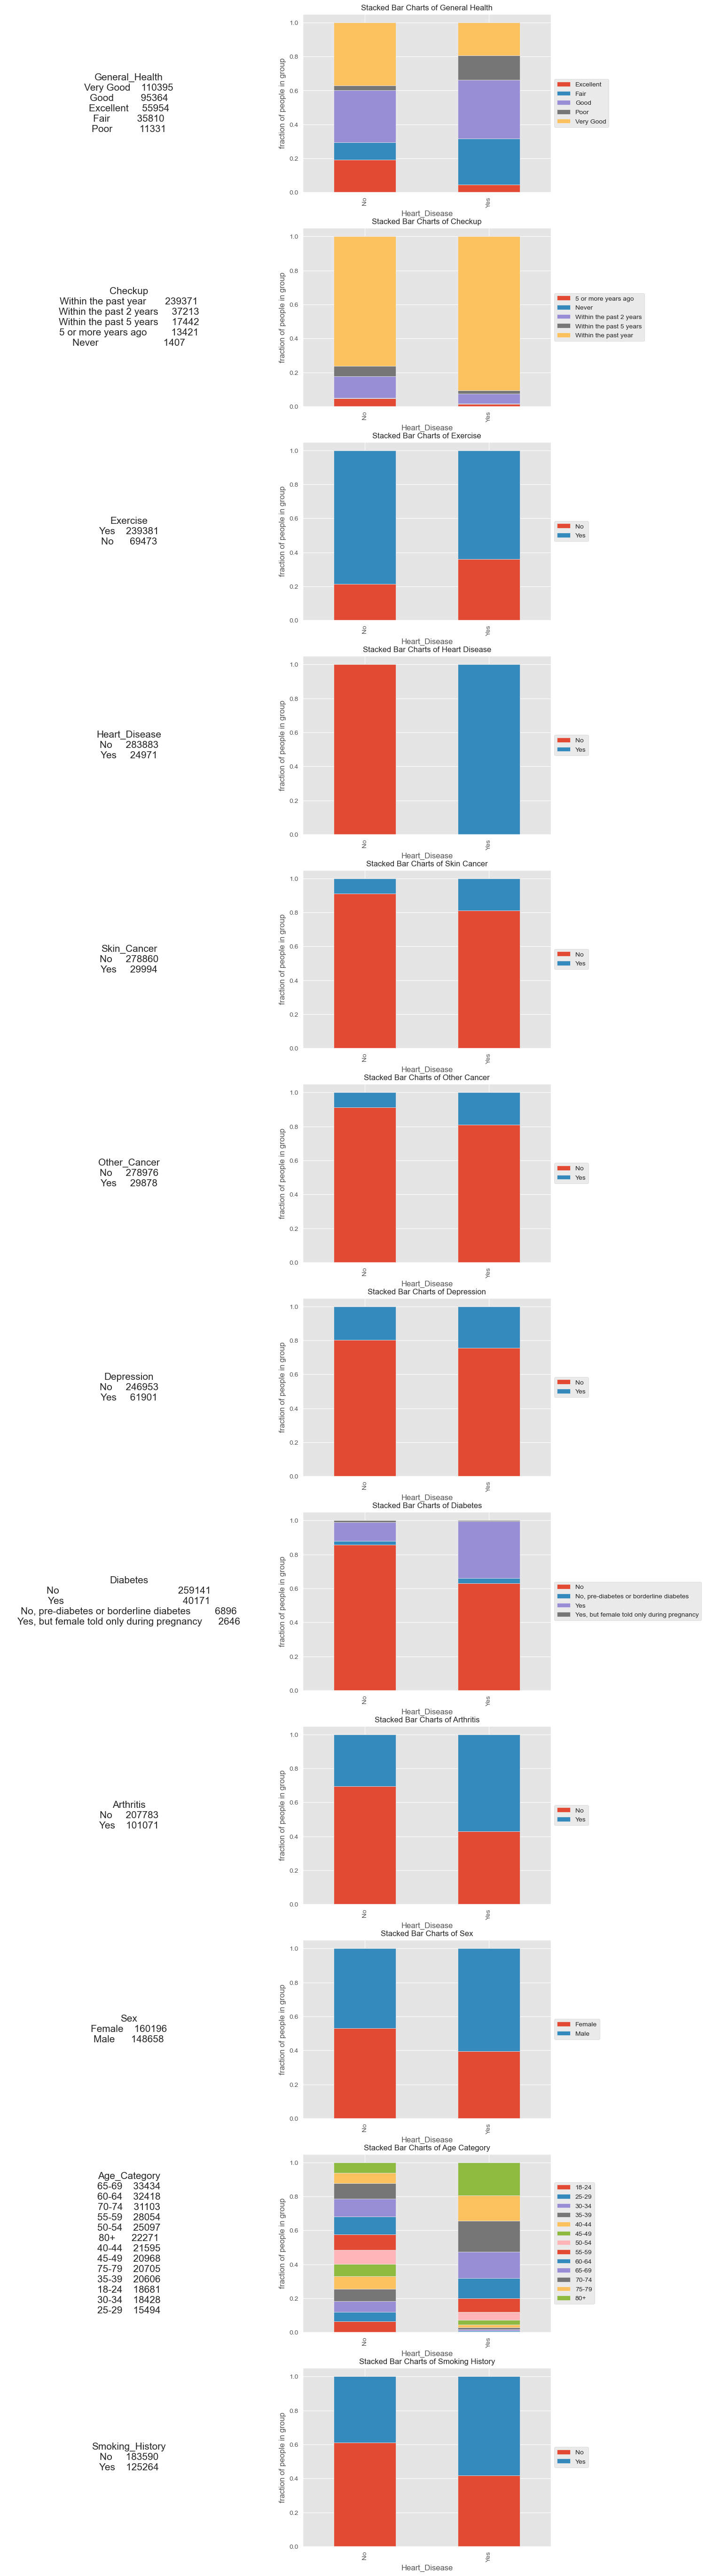

In [34]:
categorical_features = ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
                        'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
                        'Age_Category','Smoking_History']

fig, axes = plt.subplots(nrows=len(categorical_features), ncols=2, figsize=(15, 70))

for i, col in enumerate(categorical_features):
    # Descriptive statistics
    axes[i, 0].axis('off')
    stats = df[col].value_counts().to_string()
    axes[i, 0].text(0.5, 0.5, stats, fontsize=15, ha='center', va='center')


    count_matrix = df.groupby(['Heart_Disease',col]).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True, ax=axes[i, 1])
    
    axes[i, 1].set_ylabel('fraction of people in group')
    axes[i, 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    title = f'Stacked Bar Charts of {col.replace("_", " ")}'
    axes[i, 1].set_title(title, fontsize=12)

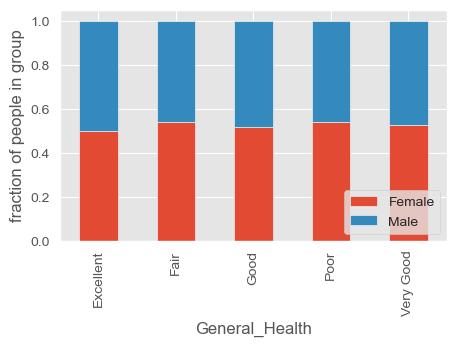

In [35]:
count_matrix = df.groupby(['General_Health','Sex']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of people in group')
plt.legend(loc=4)

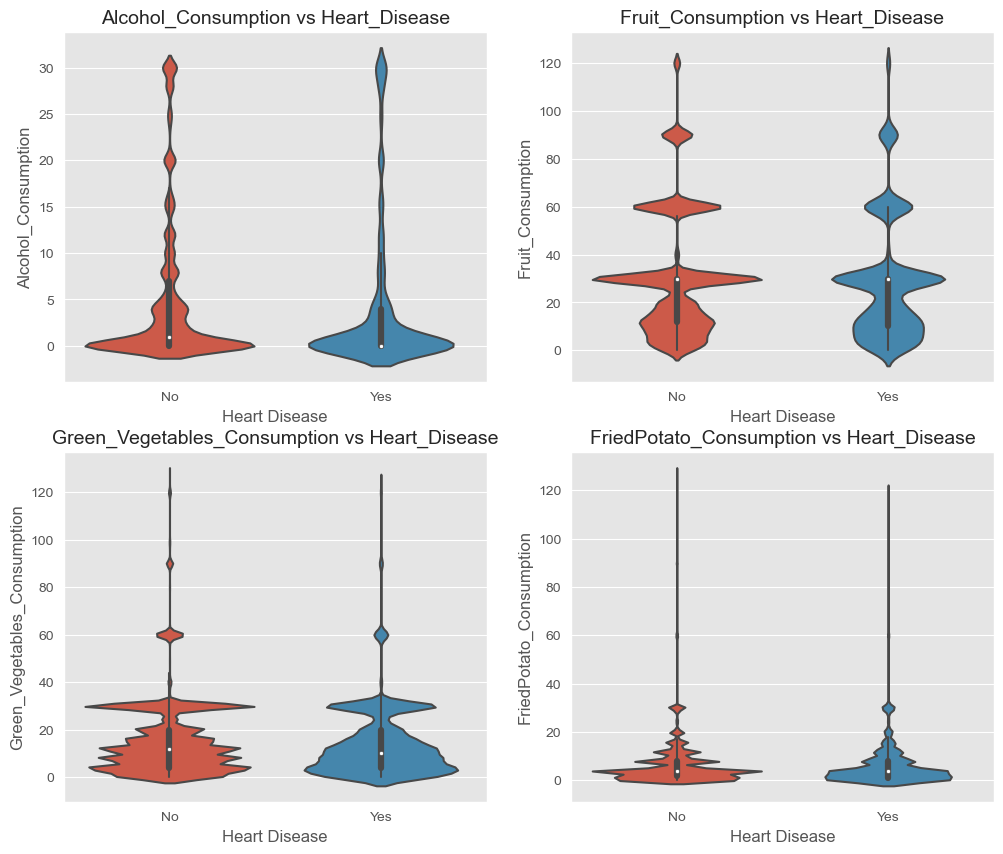

In [36]:
col_names = df.columns[-4:]
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))
ax = ax.flatten()
for i, col in enumerate(col_names):
    sns.violinplot(data=df, x='Heart_Disease', y=col, ax=ax[i])
    ax[i].set_title(f'{col} vs Heart_Disease', fontsize = '14')
    ax[i].set_ylabel(f'{col}',fontsize = '12')
    ax[i].set_xlabel('Heart Disease',fontsize = '12')

<Axes: xlabel='Heart_Disease', ylabel='BMI'>

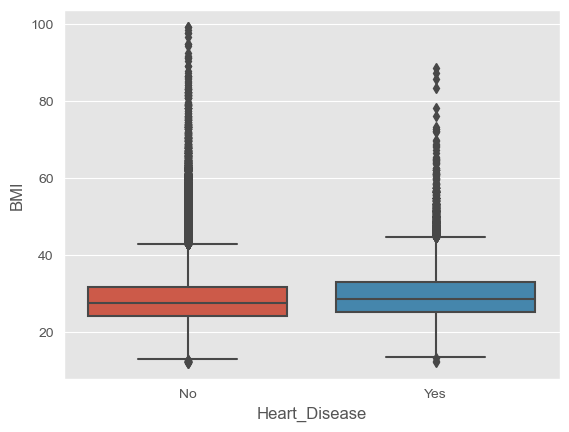

In [37]:
sns.boxplot(df,  x='Heart_Disease', y='BMI')
#df[['Age_Category','BMI','Height_(cm)','Weight_(kg)']].sort_values('BMI',ascending=False)

The figure layout has changed to tight


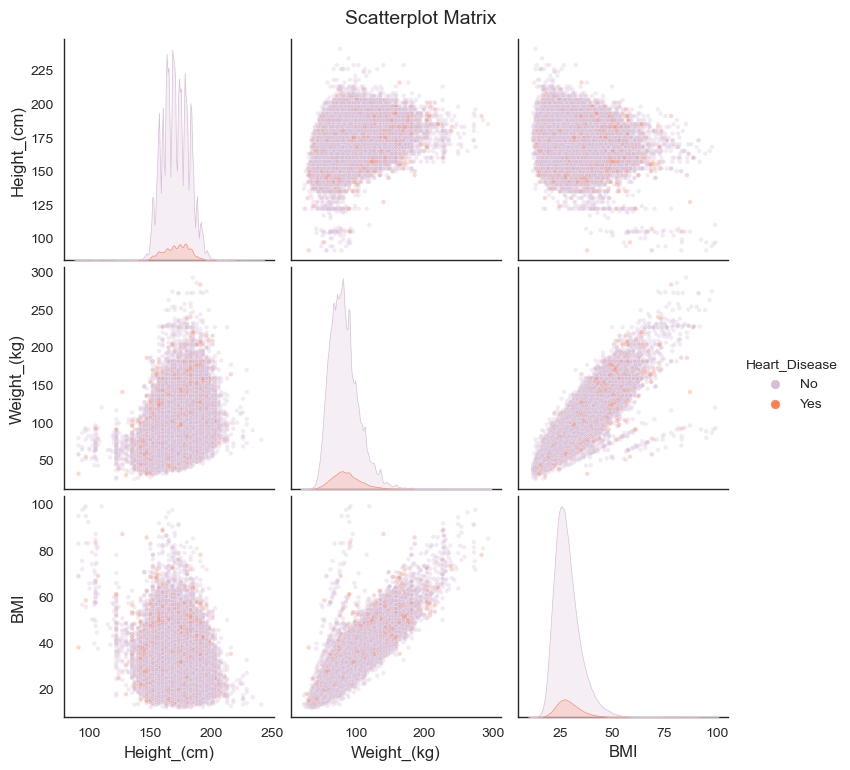

In [38]:
sns.set_style("white")
#continuous_features
g=sns.pairplot(df, vars=df.columns[11:14], hue='Heart_Disease', diag_kind='kde',
             palette={"Yes": "coral", "No": "thistle"}, plot_kws={'alpha': 0.3, 's': 10})
#g=sns.pairplot(df, vars=continuous_features, hue='Heart_Disease', diag_kind='kde',
#             palette={"Yes": "coral", "No": "thistle"}, plot_kws={'alpha': 0.3, 's': 10})

g.fig.suptitle('Scatterplot Matrix', y=1.02,fontsize = 14)

plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False);

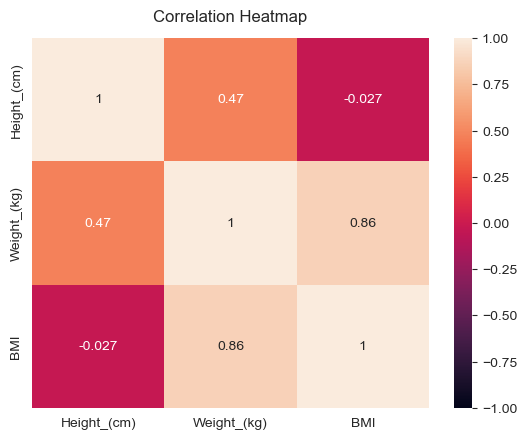

In [39]:
corr = df[df.columns[11:14]].corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

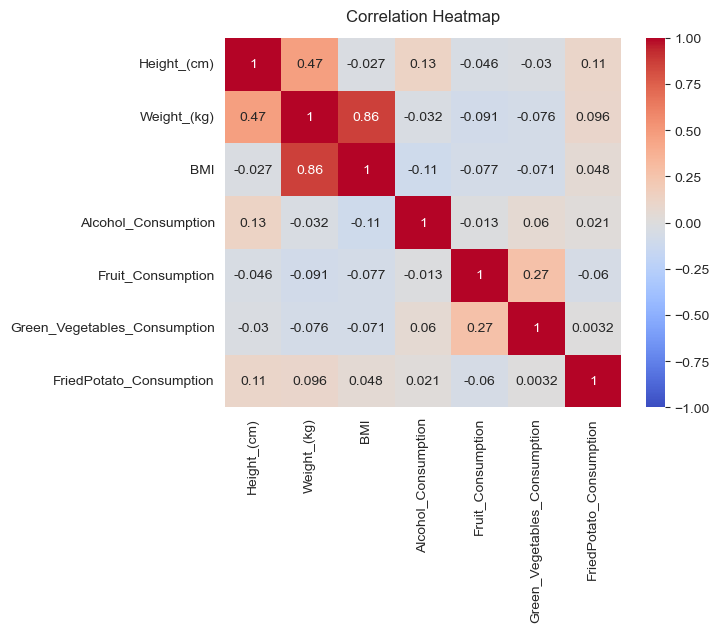

In [40]:
corr = df[continuous_features].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

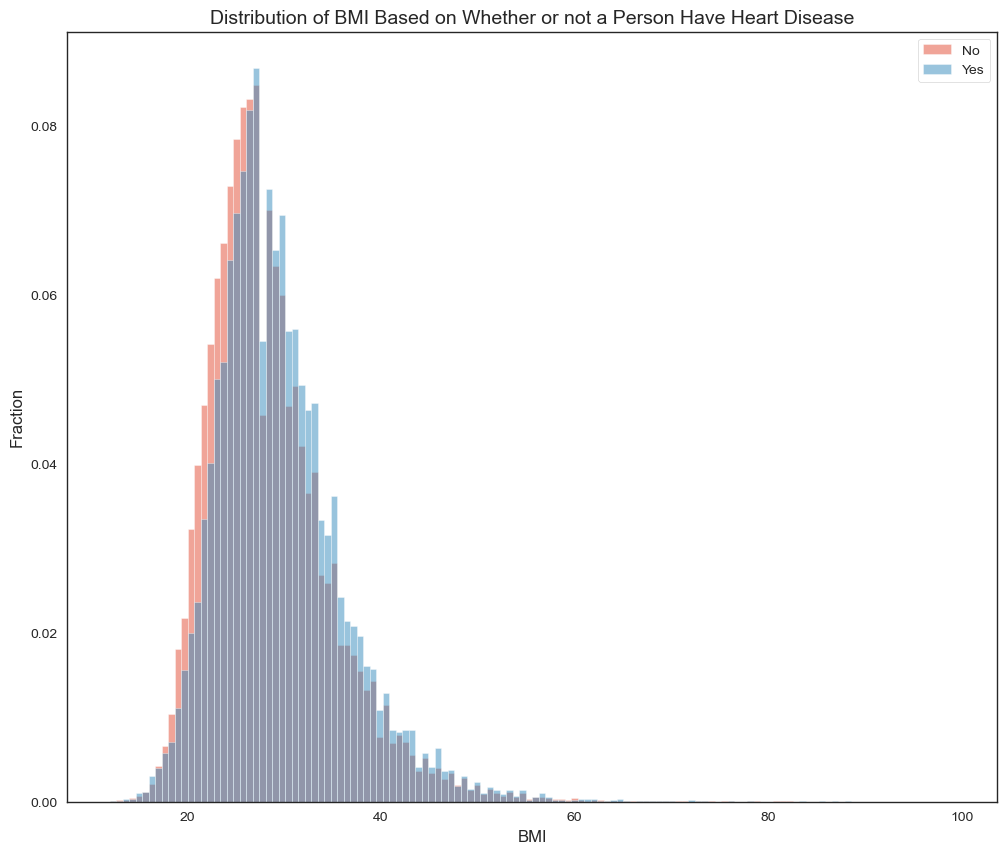

In [41]:
categories = df['Heart_Disease'].unique()
bin_range = (df['BMI'].min(),df['BMI'].max())

plt.figure(figsize=(12,10))

for c in categories:
    plt.hist(df[df['Heart_Disease']==c]['BMI'],alpha=0.5,label=c,range=bin_range,bins=130,density=True)
plt.legend()
plt.ylabel('Fraction', fontsize = 12)
plt.xlabel('BMI', fontsize = 12)
plt.title('Distribution of BMI Based on Whether or not a Person Have Heart Disease', fontsize=14)
plt.show()

### Splitting

In [42]:
random_state = 56

X = df.drop(labels=['Heart_Disease'], axis=1)
y = df['Heart_Disease']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=random_state)

print('**balance with stratification:**')
print('y_train\n:',np.unique(y_train,return_counts=True))
print('y_val\n:',np.unique(y_val,return_counts=True))
print('y_test\n:',np.unique(y_test,return_counts=True))

**balance with stratification:**
y_train
: (array(['No', 'Yes'], dtype=object), array([170329,  14983]))
y_val
: (array(['No', 'Yes'], dtype=object), array([56777,  4994]))
y_test
: (array(['No', 'Yes'], dtype=object), array([56777,  4994]))


### Preprocessing

In [43]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:\n',perc_missing_per_ftr[perc_missing_per_ftr > 0])

data dimensions: (308854, 19)
fraction of missing values in features:
 Series([], dtype: float64)


In [44]:
cat_ftrs = ['Checkup','Exercise','Skin_Cancer','Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex','Smoking_History']
ordinal_ftrs = ['General_Health','Age_Category',]
ordinal_cats = [['Poor','Fair','Good','Very Good','Excellent'],\
               ['18-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80+']]
num_ftrs = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

In [45]:
# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [46]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
feature_names = preprocessor.get_feature_names_out()

# you can convert the numpy array back to a data frame with the feature names if you want
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_val = preprocessor.transform(X_val)
df_CV = pd.DataFrame(data=df_val,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
print(feature_names)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


(185312, 32)
(61771, 32)
(61771, 32)
['num__Height_(cm)' 'num__Weight_(kg)' 'num__BMI'
 'num__Alcohol_Consumption' 'num__Fruit_Consumption'
 'num__Green_Vegetables_Consumption' 'num__FriedPotato_Consumption'
 'cat__Checkup_5 or more years ago' 'cat__Checkup_Never'
 'cat__Checkup_Within the past 2 years'
 'cat__Checkup_Within the past 5 years'
 'cat__Checkup_Within the past year' 'cat__Exercise_No'
 'cat__Exercise_Yes' 'cat__Skin_Cancer_No' 'cat__Skin_Cancer_Yes'
 'cat__Other_Cancer_No' 'cat__Other_Cancer_Yes' 'cat__Depression_No'
 'cat__Depression_Yes' 'cat__Diabetes_No'
 'cat__Diabetes_No, pre-diabetes or borderline diabetes'
 'cat__Diabetes_Yes'
 'cat__Diabetes_Yes, but female told only during pregnancy'
 'cat__Arthritis_No' 'cat__Arthritis_Yes' 'cat__Sex_Female'
 'cat__Sex_Male' 'cat__Smoking_History_No' 'cat__Smoking_History_Yes'
 'ord__General_Health' 'ord__Age_Category']


In [47]:
print('X_train before preprocessing:\n',X_train.shape)
print('X_train after preprocessing:\n',df_train.shape)

X_train before preprocessing:
 (185312, 18)
X_train after preprocessing:
 (185312, 32)
